# NATURAL LANGUAGE PROCESSING

For this project we are also considering famers who might not have access cameras or might have a hard time navigating to where an image is located.

For this giving descriptions of how the crop looks like might help this kind of famers by giving a description and our NLP model predicts if the crop disease that might be affecting that crop

Scince we did not have access to actual collected descriptions of the crops in our dataset we opted to synthesize 1751 records of actual discriptions from the internet which is in the crop_descripton.ipynb file and saved it in synthetic_data.csv file

The process involved having a dictonary of descriptions for each class and yousing adjectives and prefrixes so that the data did not have many duplicates. Out of 1751 records only 4 are duplicated.

In [2]:
import pandas as pd
des_df = pd.read_csv('synthetic_data.csv')
des_df.head()

,description,crop,status,disease,recommended_pesticide
0,Visual check indicates: notable Leaf edges rem...,Potato,Healthy,healthy,NaN
1,Farmer reports: severe Leaf edges turn brown a...,Pepper_bell,Unhealthy,Bacterial_spot,Biological predators
2,sporadic New leaves become infected almost ove...,Potato,Unhealthy,Late_blight,Sulfur spray
3,Field observation shows: moderate Spots develo...,Tomato,Unhealthy,Target_Spot,Bacillus subtilis
4,Farmer complains: notable Leaves turn bronze a...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Sulfur spray


GOAL:

Integrate this NLP pipeline into your Streamlit app so that farmers can enter symptoms and get:

Predicted disease

Recommended pesticide

In [3]:
des_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            1750 non-null   object
 1   crop                   1750 non-null   object
 2   status                 1750 non-null   object
 3   disease                1750 non-null   object
 4   recommended_pesticide  1429 non-null   object
dtypes: object(5)
memory usage: 68.5+ KB


In [4]:
# check recommended_pesticide column
des_df['recommended_pesticide'].value_counts()

recommended_pesticide
Sulfur spray            457
Neem oil                367
Horticultural oil       261
Biological predators    225
Bacillus subtilis       119
Name: count, dtype: int64

In [5]:
# drop duplicate rows
des_df = des_df.drop_duplicates()

In [6]:
des_df['recommended_pesticide'].isnull().sum()

315

In [7]:
# Replace NaNs in 'recommended_pesticide' where disease is 'healthy'
des_df.loc[(des_df['disease'] == 'healthy') & (des_df['recommended_pesticide'].isna()), 'recommended_pesticide'] = 'No pesticide needed'


In [8]:
print(des_df[des_df['recommended_pesticide'].isna()])  # Should return an empty DataFrame


Empty DataFrame
Columns: [description, crop, status, disease, recommended_pesticide]
Index: []


In [9]:
des_df['recommended_pesticide'].isnull().sum()

0

# Clean the Text

In [10]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

des_df['clean_description'] = des_df['description'].apply(clean_text)

# check the cleaned text
des_df[['description', 'clean_description']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,description,clean_description
0,Visual check indicates: notable Leaf edges rem...,visual check indicates notable leaf edge remai...
1,Farmer reports: severe Leaf edges turn brown a...,farmer report severe leaf edge turn brown crack
2,sporadic New leaves become infected almost ove...,sporadic new leaf become infected almost overn...
3,Field observation shows: moderate Spots develo...,field observation show moderate spot develop y...
4,Farmer complains: notable Leaves turn bronze a...,farmer complains notable leaf turn bronze curl...


# Vectorize Text and Encode Labels

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(des_df['clean_description'])

# Encode disease labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(des_df['disease'])

# Create lookup for pesticide recommendations
pesticide_lookup = des_df[['disease', 'recommended_pesticide']].drop_duplicates().set_index('disease')['recommended_pesticide'].to_dict()


# Train a Logistic Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


                                      precision    recall  f1-score   support

                      Bacterial_spot       1.00      1.00      1.00        46
                        Early_blight       0.98      1.00      0.99        50
                         Late_blight       1.00      1.00      1.00        44
                           Leaf_Mold       1.00      1.00      1.00        21
                  Septoria_leaf_spot       1.00      1.00      1.00        27
Spider_mites_Two_spotted_spider_mite       1.00      1.00      1.00        27
                         Target_Spot       1.00      1.00      1.00        24
        Tomato_YellowLeaf_Curl_Virus       1.00      1.00      1.00        26
                 Tomato_mosaic_virus       1.00      0.95      0.97        20
                             healthy       1.00      1.00      1.00        63

                            accuracy                           1.00       348
                           macro avg       1.00      0.99     

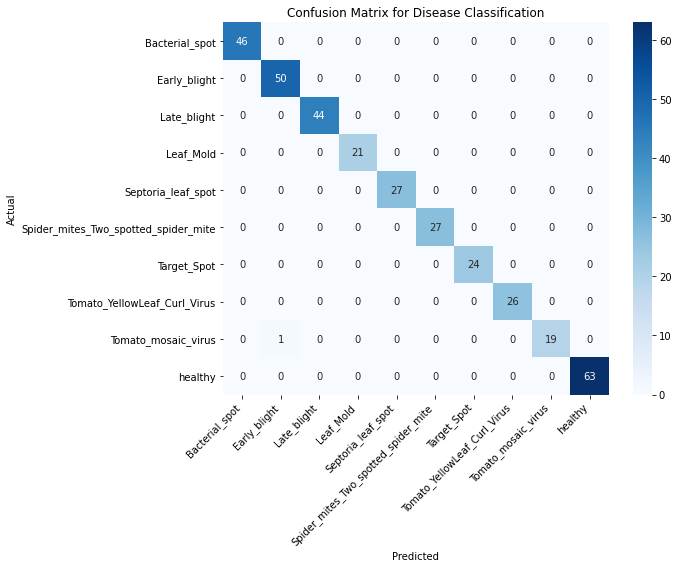

In [13]:
# Predict on the test set
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

class_labels = label_encoder.classes_


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Disease Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [14]:
# prediction function
def predict_disease(description):
    cleaned_desc = clean_text(description)
    desc_vectorized = vectorizer.transform([cleaned_desc])
    pred_label = model.predict(desc_vectorized)[0]
    disease = label_encoder.inverse_transform([pred_label])[0]
    pesticide = pesticide_lookup.get(disease, 'No recommendation available')
    return disease, pesticide

description = "The leaves of my plant are turning yellow and falling off."
disease, pesticide = predict_disease(description)
print(f"Disease: {disease}")
print(f"Recommended Pesticide: {pesticide}")


Disease: Leaf_Mold
Recommended Pesticide: Sulfur spray


In [15]:
# cleaned version
cleaned_df = des_df[['disease', 'clean_description', 'recommended_pesticide']].drop_duplicates()
cleaned_df.to_csv('cleaned_synthetic_data.csv', index=False)


In [16]:
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk


nltk.download('stopwords')
nltk.download('wordnet')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# cleaner
import string
import re

# Basic stopwords list (manually defined)
basic_stopwords = set([
    'the', 'and', 'is', 'in', 'it', 'of', 'on', 'for', 'with', 'as', 'to', 'are', 
    'that', 'this', 'a', 'an', 'at', 'by', 'be', 'from', 'has', 'have', 'but', 'was',
    'or', 'we', 'not', 'can', 'will', 'if', 'all', 'so', 'when', 'what', 'which'
])

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in basic_stopwords and len(word) > 2]
    return ' '.join(tokens)




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
import pandas as pd

# Load from CSV (adjust path if needed)
df = pd.read_csv("cleaned_synthetic_data.csv")


In [29]:
print(sorted(df['disease'].unique()))


['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites_Two_spotted_spider_mite', 'Target_Spot', 'Tomato_YellowLeaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy']


In [30]:
import os
font_path = r"C:\Windows\Fonts\arial.ttf"
if not os.path.exists(font_path):
    font_path = None  # fallback


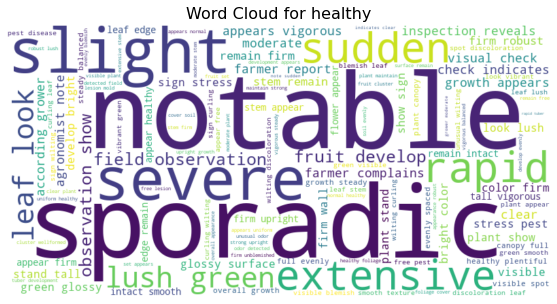

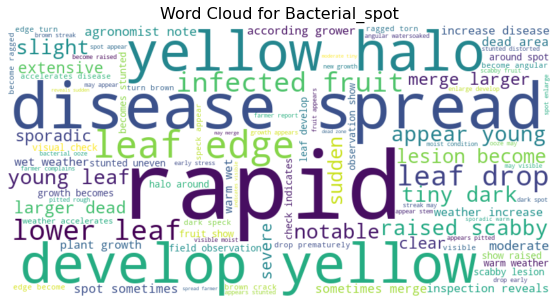

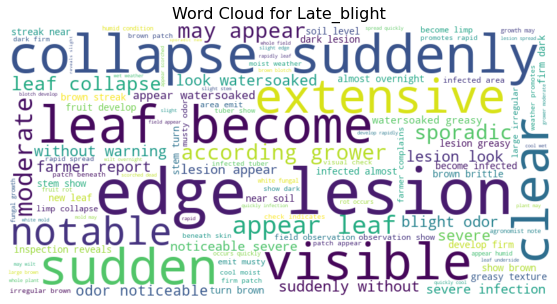

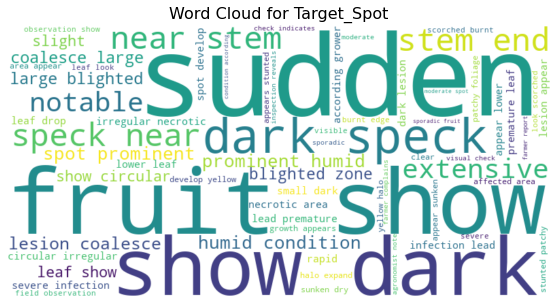

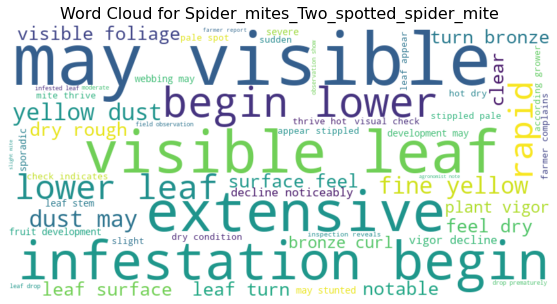

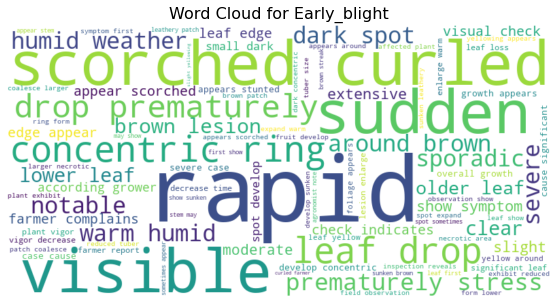

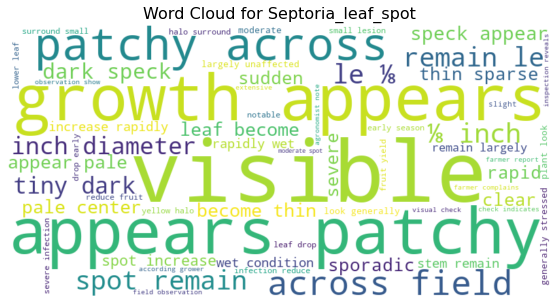

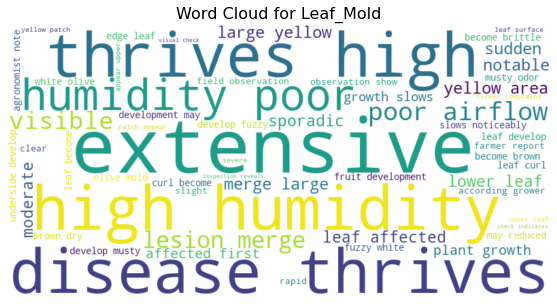

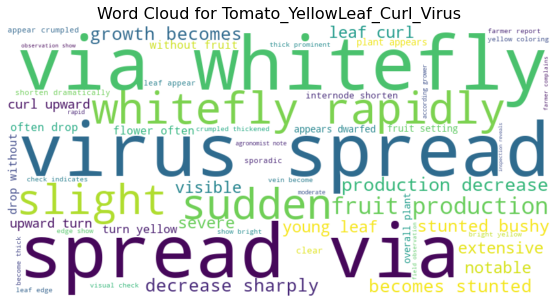

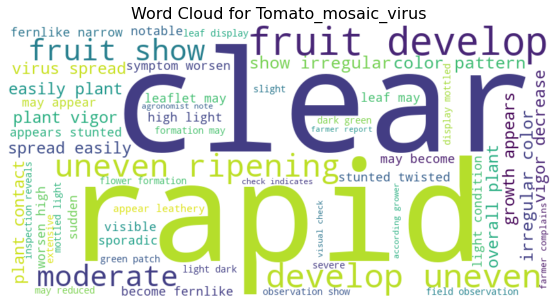

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordclouds_for_all_diseases(df, text_col='clean_description', disease_col='disease', font_path=None):
    unique_diseases = df[disease_col].unique()
    
    for disease in unique_diseases:
        subset = df[df[disease_col] == disease]
        text_blob = ' '.join(subset[text_col].dropna().astype(str))
        
        if not text_blob.strip():
            print(f"⚠️ No text found for {disease}")
            continue
        
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', font_path=font_path).generate(text_blob)
        
        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {disease}", fontsize=16)
        plt.show()

# ✅ Run the function
generate_wordclouds_for_all_diseases(df)
